In [6]:
import mne

mne.set_log_level("error")  # reduce extraneous MNE output
import pandas as pd
import numpy as np

TRAIN_PATH = "../data/raw/train/"
TRAIN_EVENTS_PATH = "../data/raw/y_train_only/"
TEST_ID = "B0403T"
H_CUT = 30
L_CUT = 1
fileName = TRAIN_PATH + TEST_ID
eventsFileName = TRAIN_EVENTS_PATH + TEST_ID
sampling_freq = 250
stiChannel = "STI101"
channel_list_fixed = ["C3", "Cz", "C4", stiChannel]
montage = mne.channels.make_standard_montage("standard_1020")
df_mne = pd.read_csv(fileName + ".csv")
df_mne.head()


,time,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03,EventStart
0,0,4.932845,6.910867,1.245421,21.489621,-33.211233,24.420024,0
1,4,6.373626,8.327228,1.074481,31.746032,-22.466422,28.815629,0
2,8,5.347985,7.008547,0.439560,28.327228,-26.373626,37.606838,0
3,12,7.692308,6.813187,0.097680,36.630037,-21.489621,53.235653,0
4,16,8.986569,5.909646,1.025641,31.257631,-15.140415,59.096459,0


In [7]:
df_event_type = pd.read_csv(eventsFileName + '.csv')
print(df_event_type.head())
print(df_event_type.info())
df_event_start = df_mne.loc[(df_mne.EventStart == 1),['time']]
df_event_start = df_event_start.reset_index(drop=True)
print(df_event_start.head())
print(df_event_start.info())
df_event_start_with_type = pd.merge(df_event_start, df_event_type, left_index=True, right_index=True)
print(df_event_start_with_type.head())
print(df_event_start_with_type.info())
# Marquage des stimuli
df_mne = pd.merge(df_mne, df_event_start_with_type, how='left', on=["time", "time"])
df_mne.head()
df_mne.info()
# Supression des information EOG et début d'événement ancien format
df_mne.drop(["EOG:ch01", "EOG:ch02", "EOG:ch03", "EventStart"], axis=1, inplace=True)
df_mne = df_mne.rename(columns={'EventType': stiChannel})
df_mne.C3 = df_mne.C3 / 1000000
df_mne.Cz = df_mne.Cz / 1000000
df_mne.C4 = df_mne.C4 / 1000000

print(df_mne.head())
print(df_mne.info())


   EventType
0          1
1          0
2          0
3          1
4          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   EventType  160 non-null    int64
dtypes: int64(1)
memory usage: 1.4 KB
None
     time
0  220396
1  230144
2  240760
3  250808
4  261172
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   time    160 non-null    int64
dtypes: int64(1)
memory usage: 1.4 KB
None
     time  EventType
0  220396          1
1  230144          0
2  240760          0
3  250808          1
4  261172          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   time       160 non-null    int64
 1   

In [8]:
# Remplacement des valuer 0-1 par 1-2 pour les stimuli, contrainte MNE
df_mne.replace({stiChannel : 1} , 2 , inplace= True)
df_mne.replace({stiChannel : 0} , 1 , inplace= True)
df_mne.fillna({stiChannel: 0 }, inplace= True)
print(df_mne.info())
print(df_mne.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468559 entries, 0 to 468558
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    468559 non-null  int64  
 1   C3      468559 non-null  float64
 2   Cz      468559 non-null  float64
 3   C4      468559 non-null  float64
 4   STI101  468559 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 17.9 MB
None
   time        C3        Cz            C4  STI101
0     0  0.000005  0.000007  1.245421e-06     0.0
1     4  0.000006  0.000008  1.074481e-06     0.0
2     8  0.000005  0.000007  4.395604e-07     0.0
3    12  0.000008  0.000007  9.768010e-08     0.0
4    16  0.000009  0.000006  1.025641e-06     0.0


In [9]:
# Intégration des informations brutes pour créer des objets MNE
data = pd.DataFrame.to_numpy(df_mne[channel_list_fixed].transpose(), dtype=np.float64)
info = mne.create_info(ch_names=channel_list_fixed, sfreq=sampling_freq, ch_types=['eeg', 'eeg','eeg', 'stim'])
raw = mne.io.RawArray(data, info)
raw.set_montage(montage)
events = mne.find_events(raw, stim_channel=stiChannel,consecutive=False)
mapping = {1: 'left', 2: 'right'}
annot_from_events = mne.annotations_from_events(
    events=events, event_desc=mapping, sfreq=raw.info['sfreq'],
    orig_time=raw.info['meas_date'])
print(annot_from_events)
raw.set_annotations(annot_from_events)


['STI101']
<Annotations | 160 segments: left (80), right (80)>


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,6 points
Good channels,"3 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


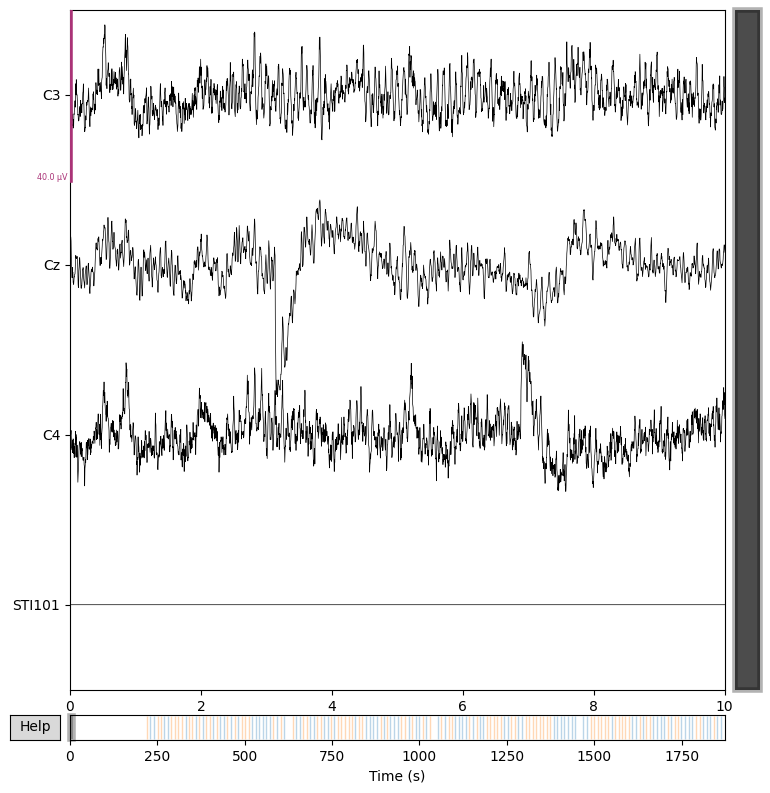

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw.plot().show()


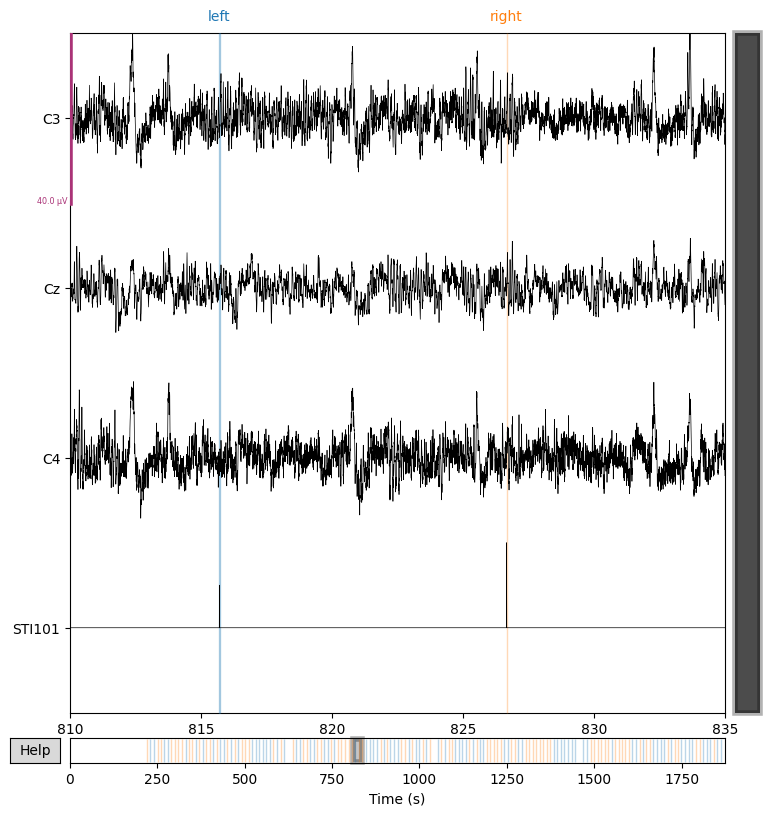

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw.plot(start=810, duration=25).show()


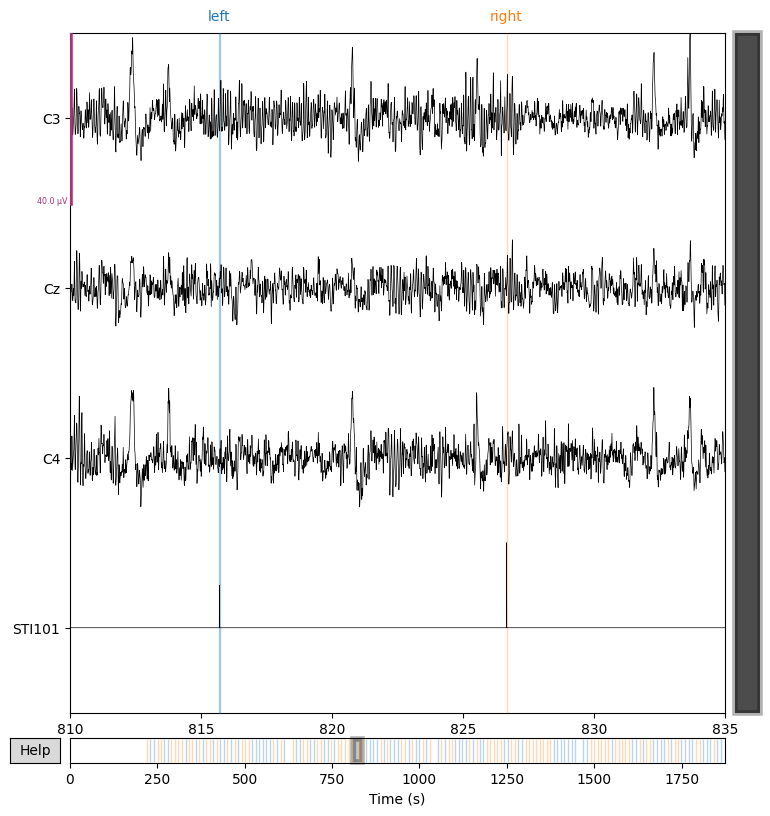

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw_filt.plot(start=810, duration=25).show()


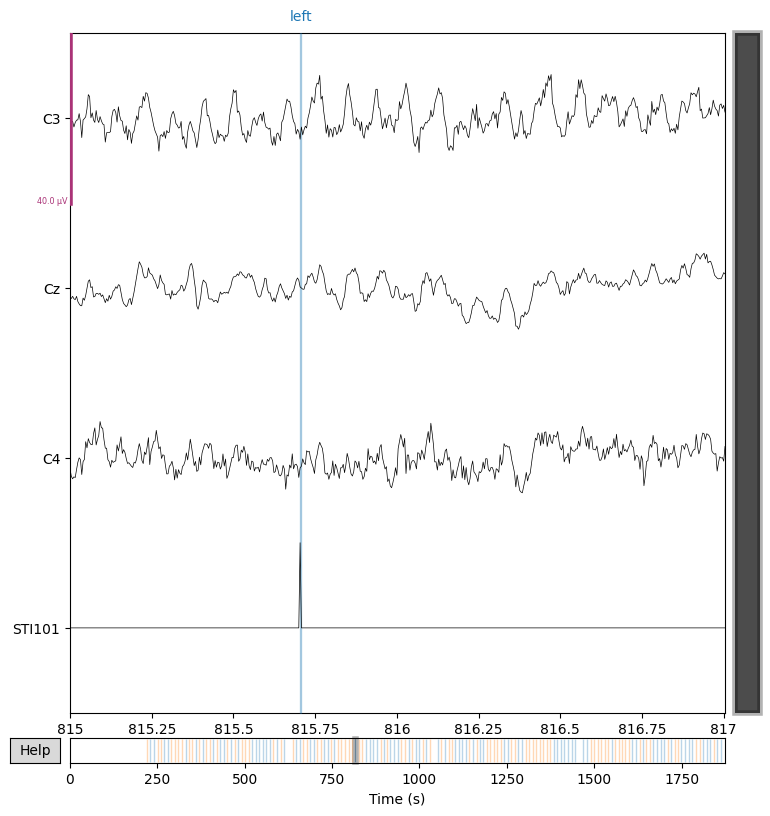

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw.plot(start=815, duration=2).show()


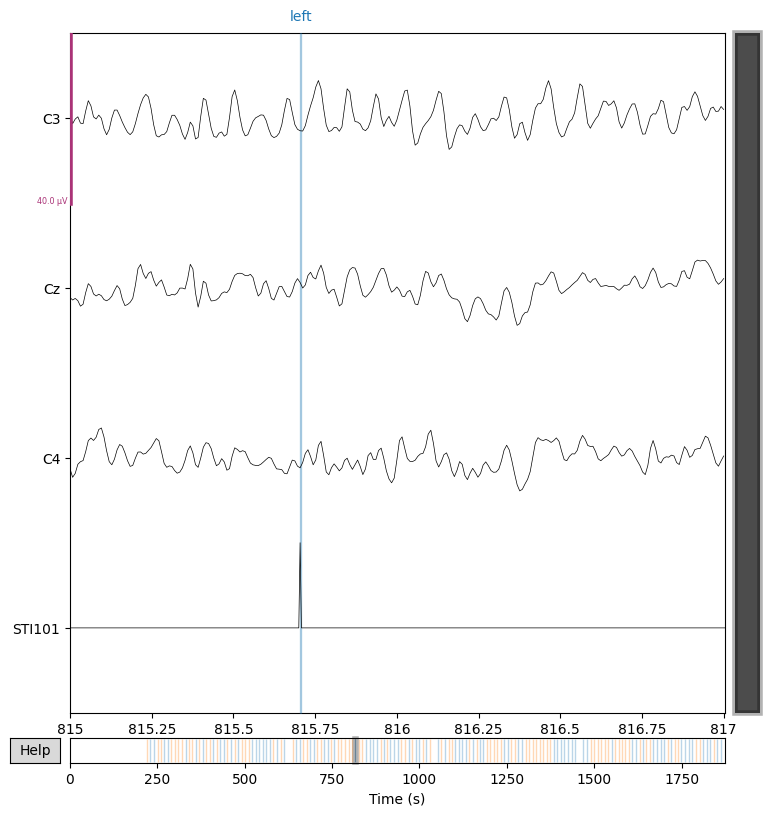

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw_filt.plot(start=815, duration=2).show()


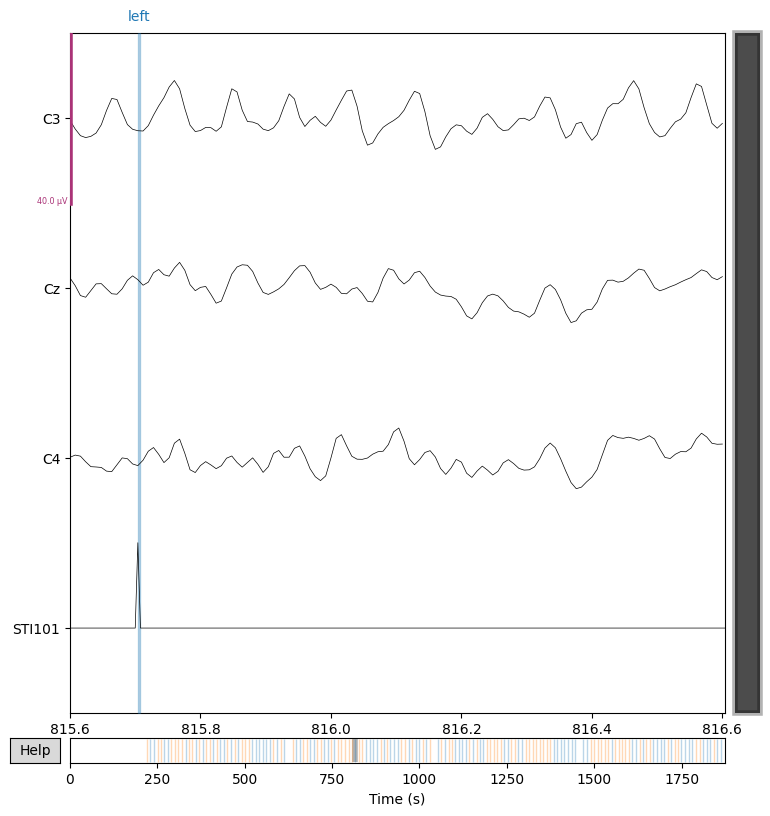

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw_filt.plot(start=815.6, duration=1).show()


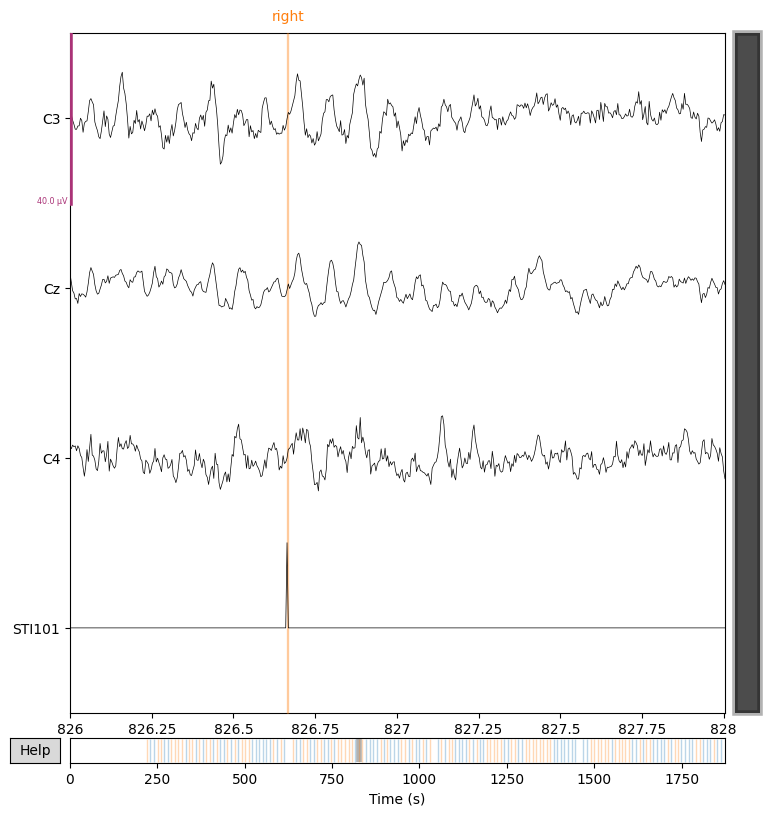

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw.plot(start=826, duration=2).show()


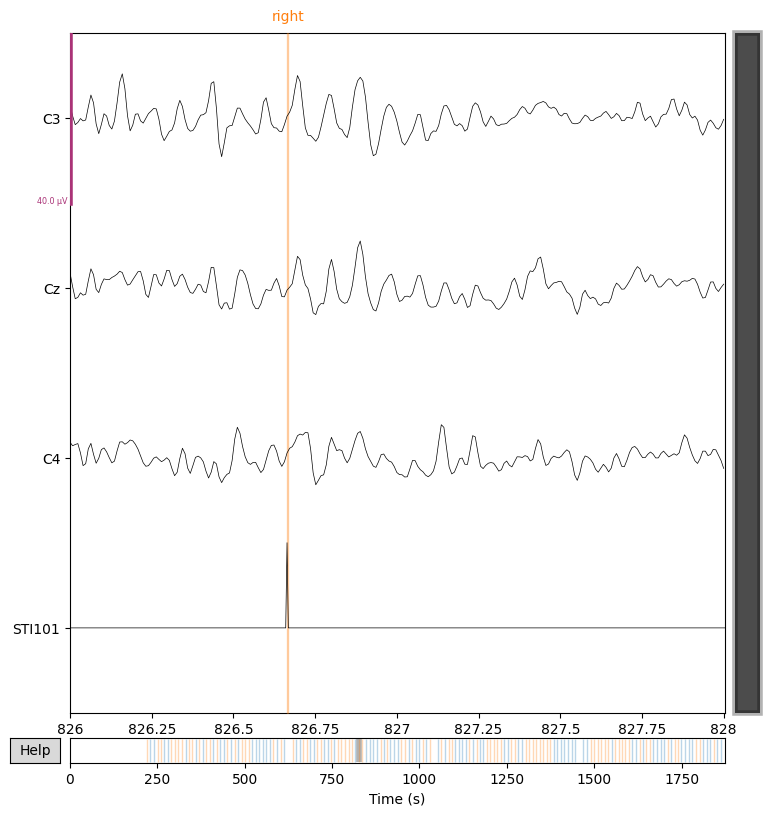

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw_filt.plot(start=826, duration=2).show()


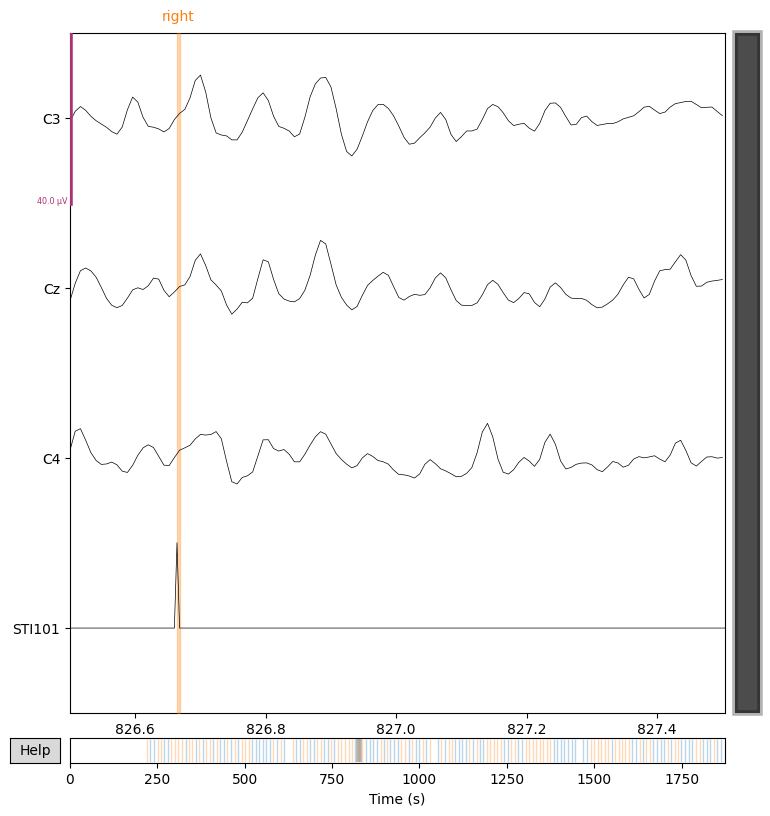

C:\Users\ebeguin\AppData\Local\Temp\ipykernel_2928\444743733.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw_filt.plot(start=826.5, duration=1).show()


In [10]:
# Représentation des signaux
# ensemble
raw.plot().show()
# application d'un filtre 0.1- 30 Hz
raw_filt = raw.copy().filter(l_freq=L_CUT, h_freq=H_CUT)

# un stimulus gauche puis droite
raw.plot(start=810, duration=25).show()
raw_filt.plot(start=810, duration=25).show()
# un stimulus gauche
raw.plot(start=815, duration=2).show()
raw_filt.plot(start=815, duration=2).show()
raw_filt.plot(start=815.6, duration=1).show()
# un stimulus droite
raw.plot(start=826, duration=2).show()
raw_filt.plot(start=826, duration=2).show()
raw_filt.plot(start=826.5, duration=1).show()


d:\perso\Informatique\Formations\ProjetData\mar24_cds_eeg\.venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


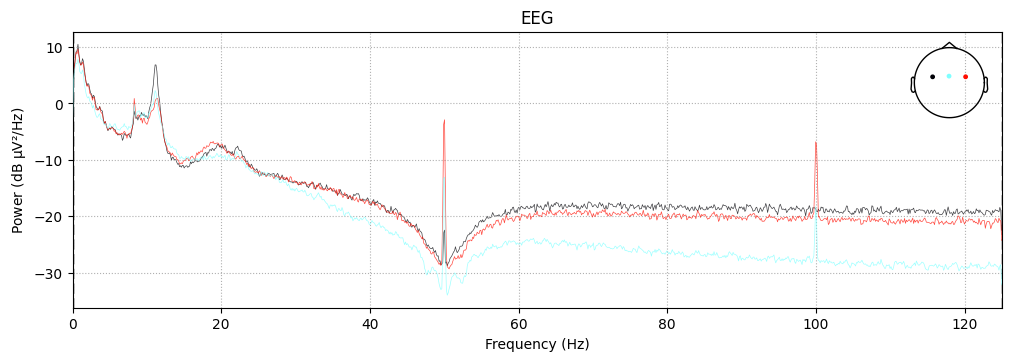

In [11]:
raw.compute_psd().plot()


d:\perso\Informatique\Formations\ProjetData\mar24_cds_eeg\.venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


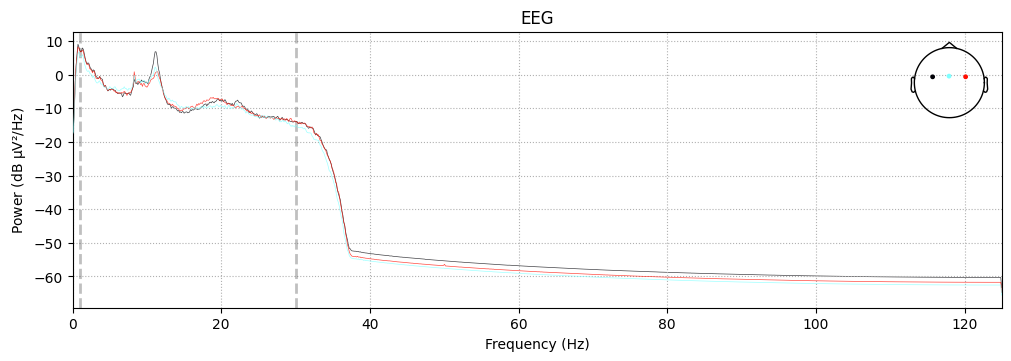

In [12]:
raw_filt.compute_psd().plot()



d:\perso\Informatique\Formations\ProjetData\mar24_cds_eeg\.venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


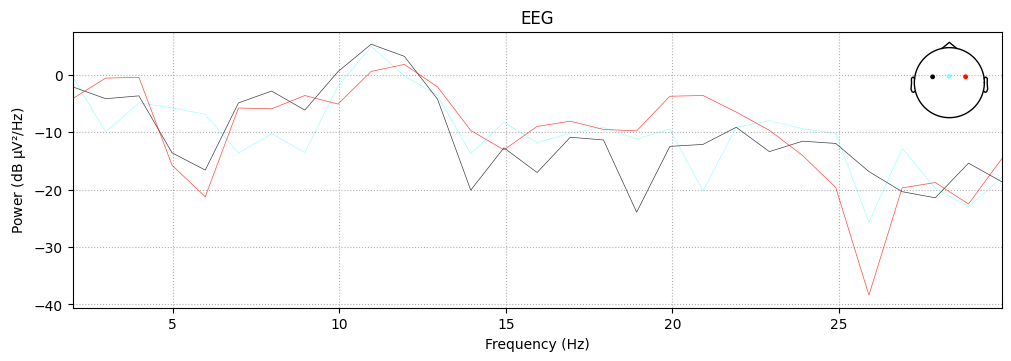

In [20]:
# psd Droite
raw_filt.compute_psd(tmin=826.624, tmax=827.624, fmin=1, fmax=30, picks="eeg").plot()

d:\perso\Informatique\Formations\ProjetData\mar24_cds_eeg\.venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


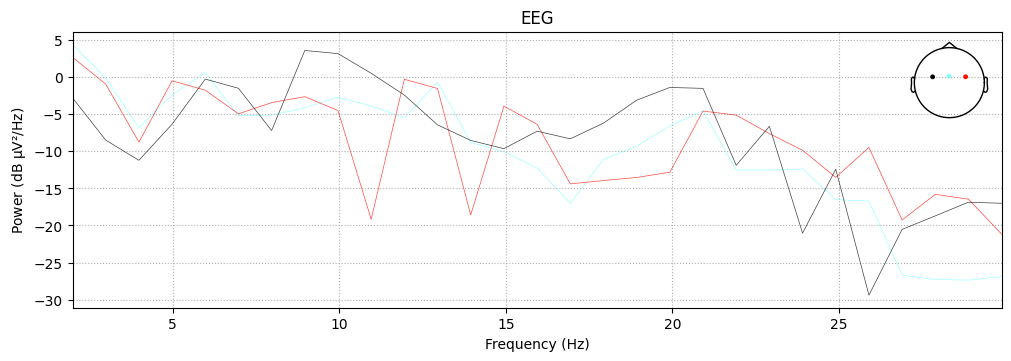

In [19]:
# psd Gauche
raw_filt.compute_psd(tmin=815.704, tmax=816.704, fmin=1, fmax=30, picks="eeg").plot()

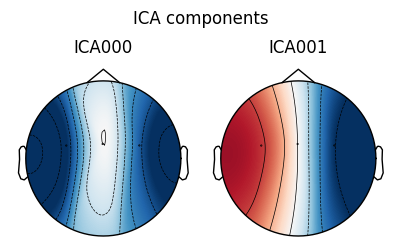

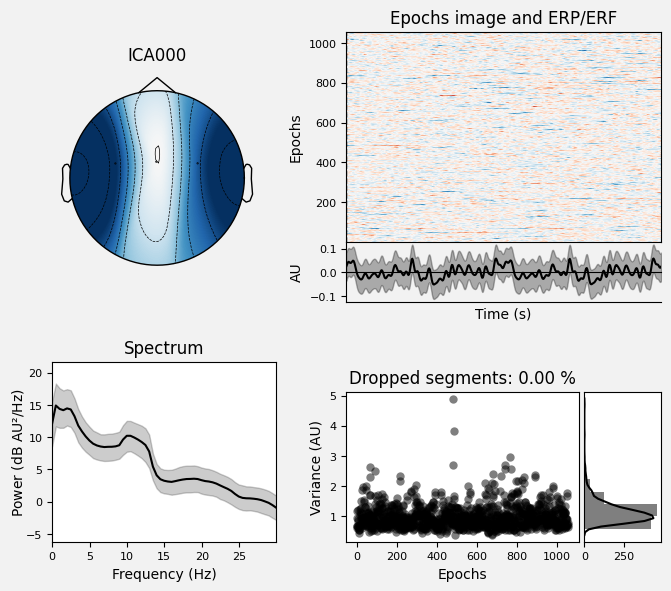

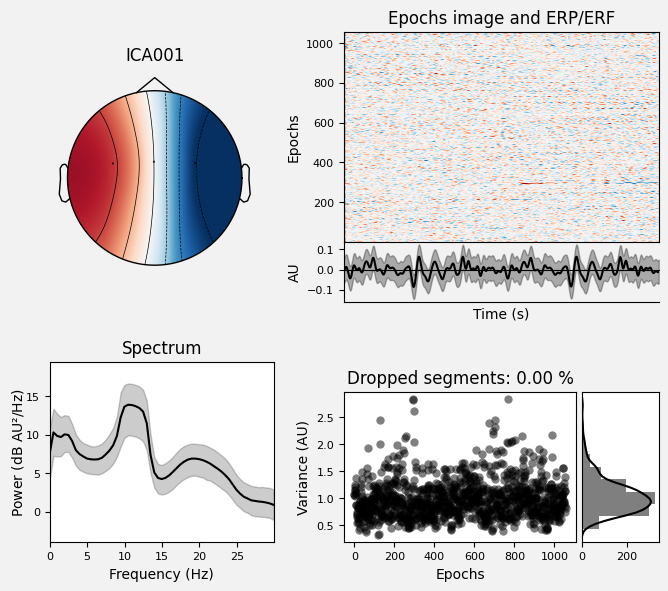

In [68]:

# ICA stimulus gauche
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica_left = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
raw_left_ica = raw_filt.copy()
tstep = 1
events_left_ica = mne.make_fixed_length_events(raw_left_ica, start=815.704, duration=tstep)
epochs_left_ica = mne.Epochs(raw_left_ica, events_left_ica,
                               tmin=0,
                               tmax=2,
                        baseline=None,
                        preload=True).set_eeg_reference(ref_channels=['Cz'])
ica_left.fit(epochs_left_ica, decim=3)
ica_left.plot_components();

ica_left.plot_properties(epochs_left_ica, picks=range(0, ica_left.n_components_), psd_args={'fmax': H_CUT});



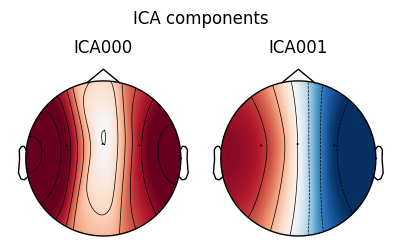

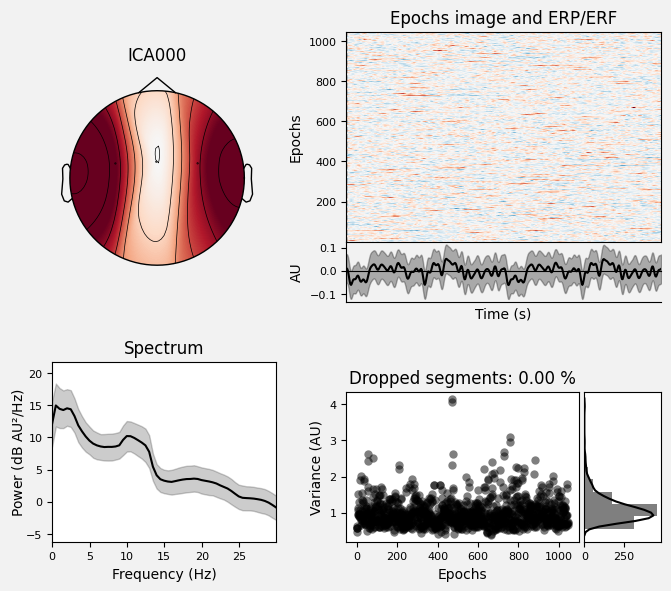

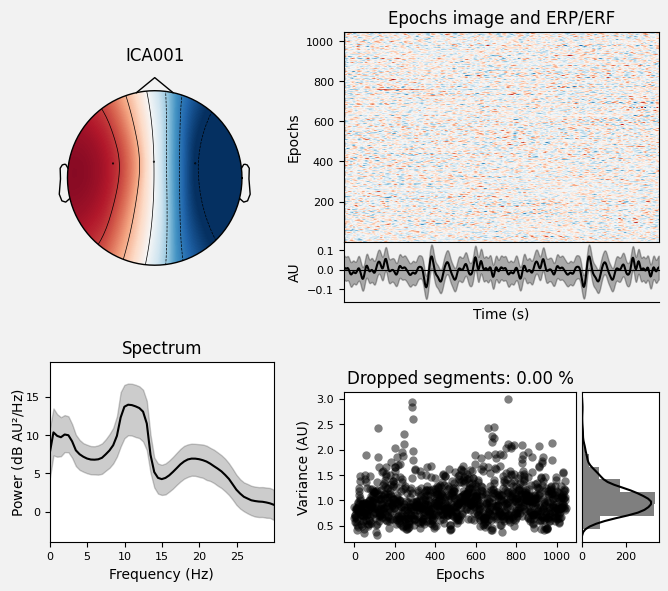

In [69]:
# ICA stimulus droit
ica_right = mne.preprocessing.ICA(
    n_components=ica_n_components,
    random_state=random_state,
)
raw_rigth_ica = raw_filt.copy()
tstep = 1
events_right_ica = mne.make_fixed_length_events(raw_rigth_ica, start=826.624, duration=tstep)
epochs_right_ica = mne.Epochs(
    raw_rigth_ica, events_right_ica, tmin=0, tmax=2, baseline=None, preload=True
).set_eeg_reference(ref_channels=['Cz'])
ica_right.fit(epochs_right_ica, decim=30)
ica_right.plot_components();

ica_right.plot_properties(
    epochs_right_ica, picks=range(0, ica_right.n_components_), psd_args={"fmax": H_CUT}
);

['STI101']


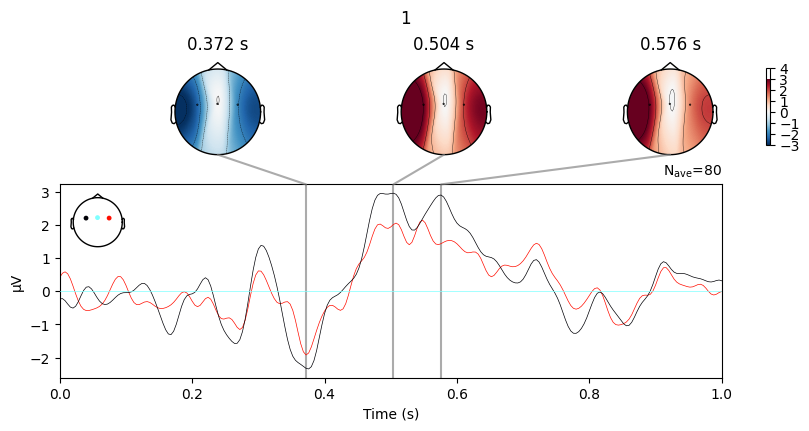

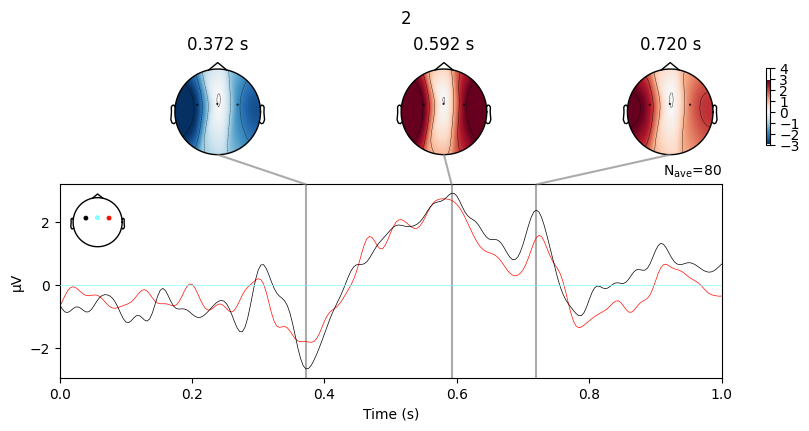

In [70]:
import matplotlib.pyplot as plt

raw_for_evoked = raw_filt.copy()
events = mne.find_events(raw_for_evoked, stim_channel=stiChannel, consecutive=False)
epochs_evoked = mne.Epochs(
    raw_for_evoked, events, tmin=0, tmax=1, baseline=None, preload=True
)
conditions = ["1", "2"]
evoked = {c: epochs_evoked[c].set_eeg_reference(ref_channels=['Cz']).average() for c in conditions}
for c in evoked.keys():
    evoked[c].plot_joint(title=c)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))



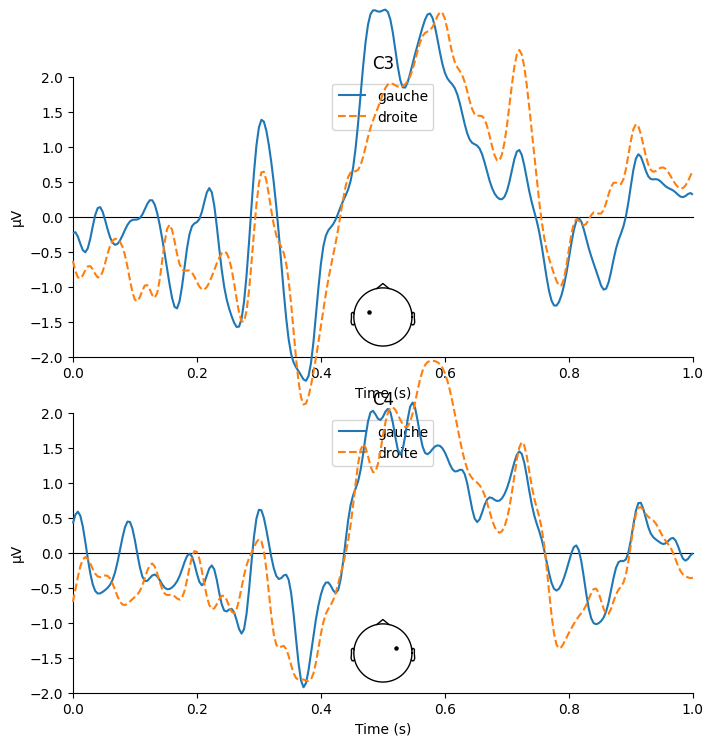

In [73]:
# comparaison des signaux moyens Droite/Gauche
evokeds_avgref = {c:evoked[c].copy().set_eeg_reference(ref_channels=['Cz']) 
                  for c in evoked.keys()
                  }
channels_to_plot = ["C3", "C4"]
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
linestyle_dict = {"gauche": "-", "droite": "--"}

for idx, chan in enumerate(channels_to_plot):
    mne.viz.plot_compare_evokeds(
        {
            "gauche": evokeds_avgref["1"],
            "droite": evokeds_avgref["2"],
        },
        picks=chan,
        ylim={"eeg": (-2, 2)},
        show_sensors="lower center",
        legend="upper center",
        linestyles=linestyle_dict,
        axes=axes.reshape(-1)[idx],
        show=False,
    )
plt.show()


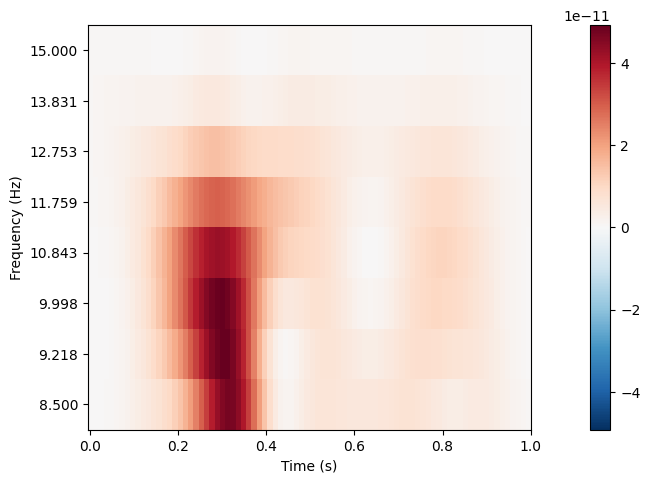

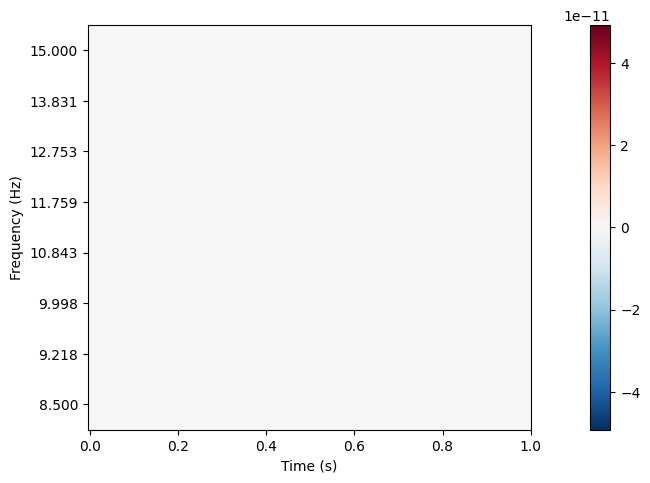

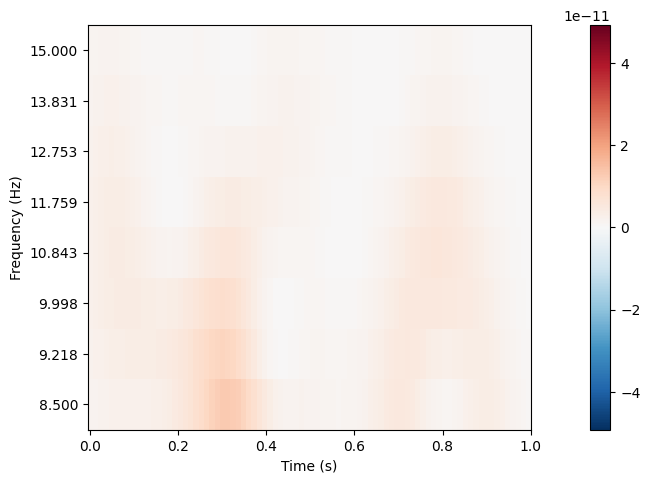

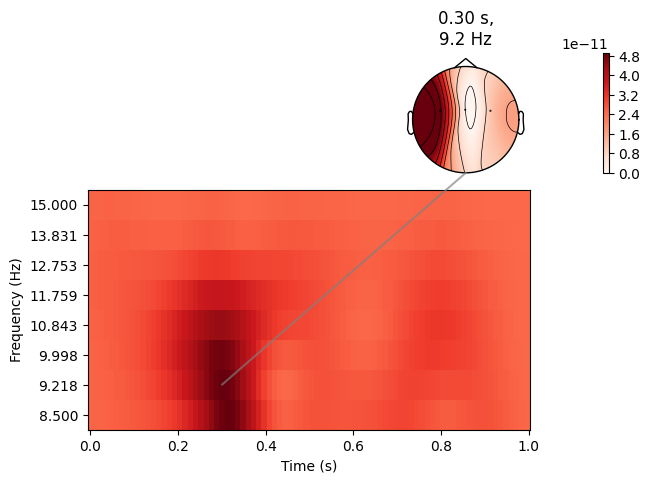

In [74]:
freqs = np.logspace(*np.log10([8.5, 15]), num=8)
n_cycles = freqs / 2.0
powerLeft = evokeds_avgref["1"].compute_tfr(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    decim=3,
)
powerLeft.plot();
powerLeft.plot_joint(mode="median");


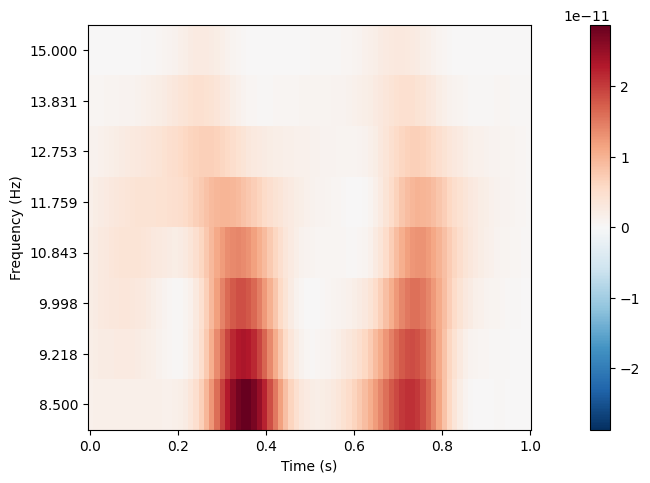

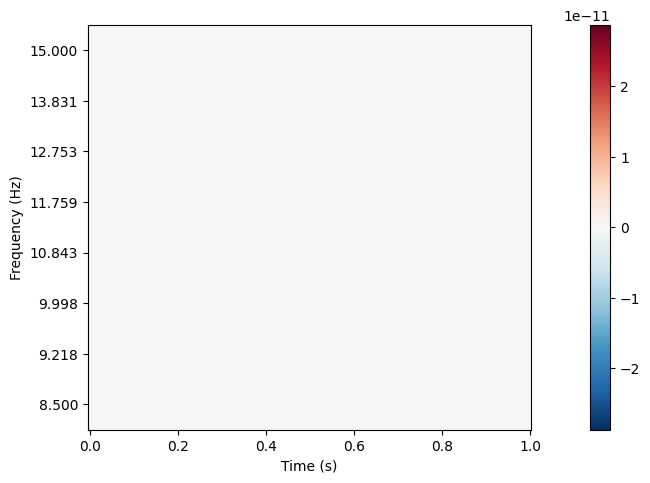

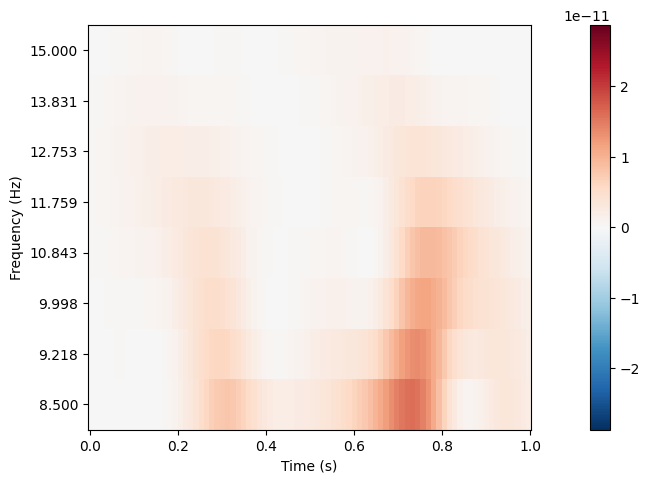

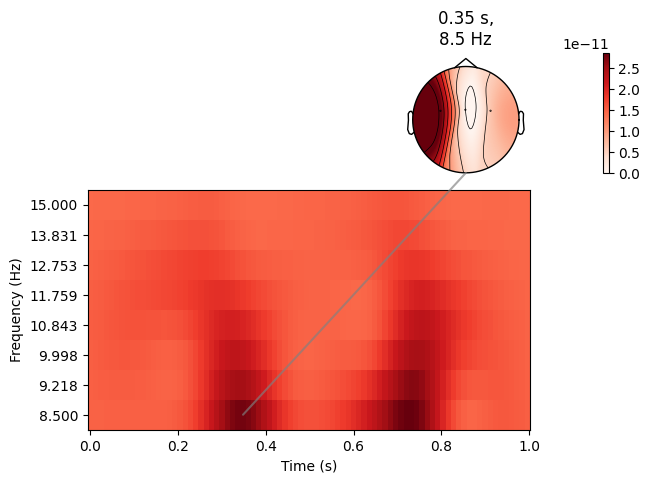

In [75]:
freqs = np.logspace(*np.log10([8.5, 15]), num=8)
n_cycles = freqs / 2.0
powerRight = evokeds_avgref["2"].compute_tfr(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    decim=3,
)
powerRight.plot();
powerRight.plot_joint(mode="median");
